In [2]:
from sbcbinaryformat import Streamer, Writer
import numpy as np
import matplotlib.pyplot as plt

from GetEvent import GetEvent

from ana import AcousticT0 
from scipy.signal import firwin, filtfilt
from scipy.optimize import least_squares
import importlib

In [3]:
importlib.reload(AcousticT0)

<module 'ana.AcousticT0' from '/exp/e961/app/users/runze/projects/LAr10Ana/ana/AcousticT0.py'>

In [4]:
TEST_RUN = "/exp/e961/data/SBC-25-daqdata/20250611_1/"
TEST_RUN2 = "/exp/e961/app/users/runze/data/20251120_12/"
# TEST_RUN2 = "/exp/e961/data/users/gputnam/SBC-25-daqdata-test/20251103_1/"
TEST_EVT = 1

In [6]:
data = GetEvent(TEST_RUN2, TEST_EVT,strictMode=False)

In [7]:
data["slow_daq"].keys()

dict_keys(['loaded', 'time_ms', 'valves', 'TT6415', 'PT1101', 'TT2118', 'TT2119', 'PT2121', 'PT3332', 'PT3333', 'CYL3334_FCALC', 'LT3335', 'SERVO3321_OUT', 'SERVO3321_IN'])

In [10]:
data["slow_daq"]['PT2121']


array([19.73877 , 19.737701, 19.748383, ..., 19.94812 , 19.944916,
       19.943848], shape=(11790,), dtype=float32)

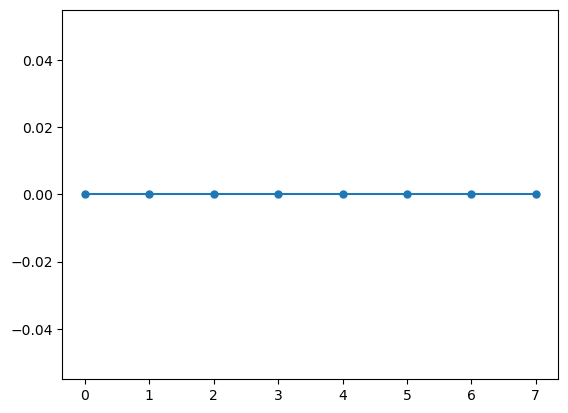

In [110]:
# DC Offset by channel
_ = plt.plot(data["acoustics"]["DCOffset"][0], marker=".", markersize=10)

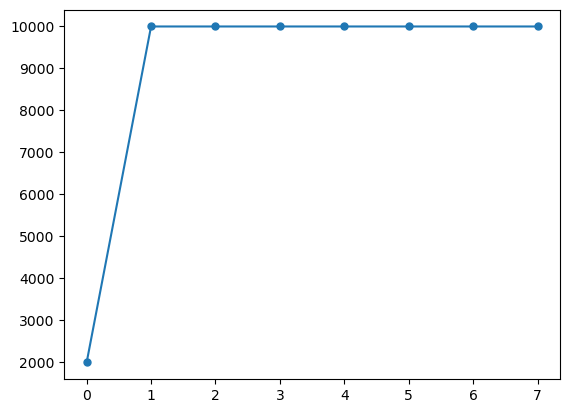

In [111]:
# DC Offset by channel
_ = plt.plot(data["acoustics"]["Range"][0], marker=".", markersize=10)

In [112]:
wvfs = data["acoustics"]["Waveforms"]
wvfs.shape

(1, 8, 950001)

In [113]:
np.float64([[1e2, 1e3, 1e4, 1e5]]).shape

(1, 4)

Text(0, 0.5, 'pressure/psi')

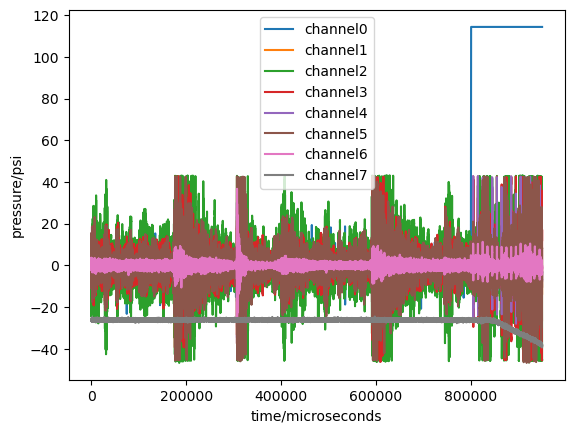

In [114]:
# plot the first triggered waveform in each channel
# if channel 7 raw reading is ADC -35/1e4
# if channel 7 raw reading is bits, -35/2**15
# MB.PT1101 := AIn.PT1101 * (-35.0* el3052bits);
#wvfs_psi = wvfs*(35/2**15)
wvfs_psi = wvfs*(35/1e4)

for channel in range(wvfs.shape[1]):
    plt.plot(wvfs_psi[0, channel, :],label="channel"+str(channel))
    #plt.plot(wvfs[0, channel, :],label="channel"+str(channel))
plt.legend()
plt.xlabel("time/microseconds")
plt.ylabel("pressure/psi")
# channel 0 hydraulic trigger 15bits
# channel 1-6 acoustic
# channel 7, PT 
# that is when compress happens, and with a delay, the pressure drops

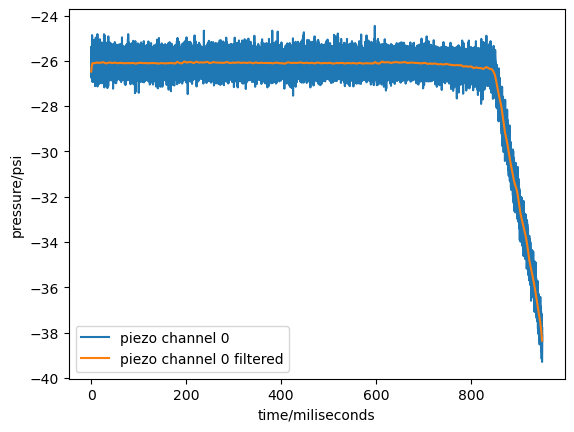

In [122]:
piezo0 = wvfs_psi[0, 7, :]
xlimit = [0, 800]
ylimit = [-22.5,-20]
ylimit = [-20,-18]
# time in miliseconds
total_time = len(piezo0)
time_list_ms = [i/1e3 for i in range(0,total_time,1)]

# add low pass filter
# assuming 1 microsecond time resolution 1e6Hz
numtaps = 5000  # filter length (longer = sharper cutoff)
Fs= 1000000 # sampling rate
Fc = 10 # low pass filter in Hz
fir = firwin(numtaps, Fc, window='hamming', fs=Fs)

piezo0_filtered = filtfilt(fir, [1.0], piezo0)
piezoslope0 = -piezo0_filtered[1:]+piezo0_filtered[:-1]
plt.plot(time_list_ms,piezo0, label="piezo channel 0")
plt.plot(time_list_ms,piezo0_filtered, label="piezo channel 0 filtered")
plt.xlabel("time/miliseconds")
plt.ylabel("pressure/psi")
# plt.xlim(xlimit)
# plt.ylim(ylimit)
plt.legend()

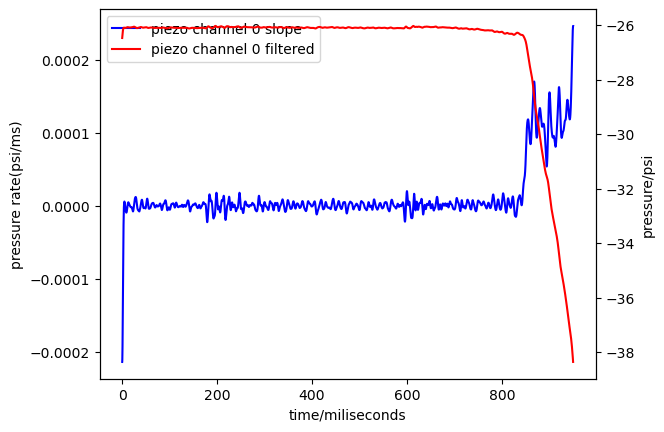

In [123]:
fig, ax1 = plt.subplots()

# First axis
l1 = ax1.plot(time_list_ms[:-1],piezoslope0, label="piezo channel 0 slope",color="blue")

ax1.set_xlabel("time/miliseconds")
ax1.set_ylabel("pressure rate(psi/ms)")
# ax1.tick_params(axis='y', labelcolor="blue")

# Second axis (shares X)
ax2 = ax1.twinx()
l2 = ax2.plot(time_list_ms,piezo0_filtered, label="piezo channel 0 filtered",color="red")
ax2.set_ylabel("pressure/psi")
# ax2.set_ylim(ylimit)

lines = l1 + l2
labels = [line.get_label() for line in lines]

ax1.legend(lines, labels)
# plt.legend()

In [124]:
#quadratic fittings
# finding ending point, hard cut, find first time when the rate > 1e-4 psi/ms
# starting point, from [10:]
# then fitting find t0

starting_indx = 10000
# starting 10ms after data collection
print(piezoslope0[starting_indx])
ending_indx = 0
hardcut_threshold = 1e-4
for i in range(starting_indx,len(piezoslope0),1):
    if piezoslope0[i] > hardcut_threshold:
        ending_indx = i
        
        break
# print("index",ending_indx)
pressure_before_fit = piezo0_filtered[starting_indx:ending_indx]
time_fit_range = time_list_ms[starting_indx:ending_indx]

-6.452186827488049e-06


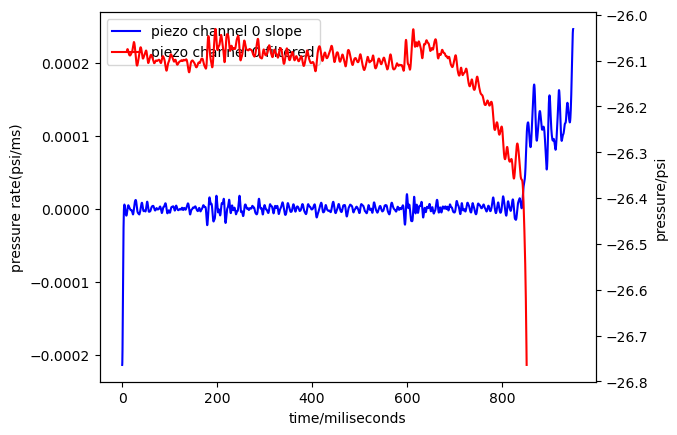

In [125]:
fig, ax1 = plt.subplots()

# First axis
l1 = ax1.plot(time_list_ms[:-1],piezoslope0, label="piezo channel 0 slope",color="blue")

ax1.set_xlabel("time/miliseconds")
ax1.set_ylabel("pressure rate(psi/ms)")
# ax1.tick_params(axis='y', labelcolor="blue")

# Second axis (shares X)
ax2 = ax1.twinx()
l2 = ax2.plot(time_fit_range,pressure_before_fit, label="piezo channel 0 filtered",color="red")
ax2.set_ylabel("pressure/psi")


# ax2.set_ylim(ylimit)

lines = l1 + l2
labels = [line.get_label() for line in lines]

ax1.legend(lines, labels)
# plt.legend()

In [118]:
#qua fit
coeffs = np.polyfit(time_fit_range, pressure_before_fit, 2)
a, b, c = coeffs
print(a, b, c)

# find t0
t0_fitted = round(-b/(2*a),3)
print(a,b,c)

-7.566948224344979e-07 0.0004908010549070054 -26.14162817467616
-7.566948224344979e-07 0.0004908010549070054 -26.14162817467616


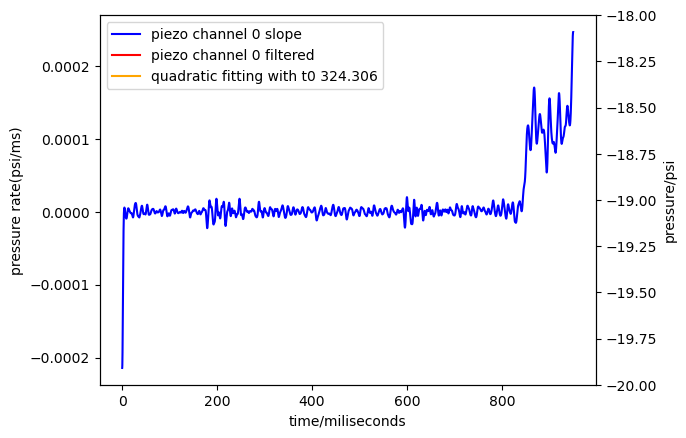

In [119]:
# generate the fitting and plot it in the same graph
qua_fitting = [round(a*i**2+b*i+c,3) for i in time_fit_range]


fig, ax1 = plt.subplots()

# First axis
l1 = ax1.plot(time_list_ms[:-1],piezoslope0, label="piezo channel 0 slope",color="blue")
ax1.set_xlabel("time/miliseconds")
ax1.set_ylabel("pressure rate(psi/ms)")
# ax1.tick_params(axis='y', labelcolor="blue")



# Second axis (shares X)
ax2 = ax1.twinx()
l2 = ax2.plot(time_list_ms,piezo0_filtered, label="piezo channel 0 filtered",color="red")
# quadratic fitting
l3 = ax2.plot(time_fit_range,qua_fitting, label="quadratic fitting with t0 "+str(t0_fitted),color="orange")
ax2.set_ylabel("pressure/psi")
ax2.set_ylim(ylimit)

lines = l1 + l2+ l3
labels = [line.get_label() for line in lines]

ax1.legend(lines, labels)

In [120]:
def piecewise_with_t(params, x):
    a, t, c = params
    y = np.where(x < t, c, a*(x - t)**2 + c)
    return y

def residuals_with_t(params, x, y):
    return piecewise_with_t(params, x) - y

fitted a, t, c: -1.0305833738745922e-05 668.09060610767 -26.089963886685492


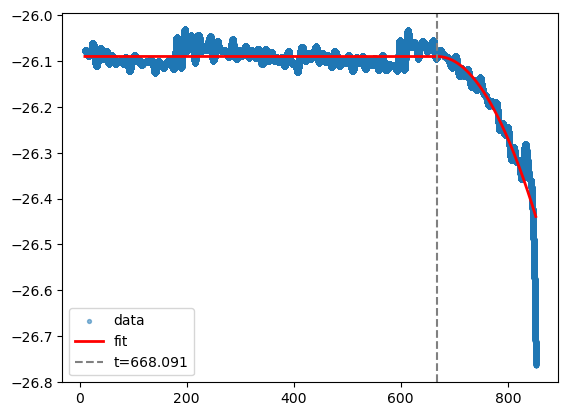

In [121]:
# fit with function
# f =c when x<t0,
# f=a(x-t0)**2+c when x>t0

# initial guesses:
a0 = -8e-6
t0 = 100             # t0 initial guess around 100ms
c0 = np.mean(pressure_before_fit[:100]) # first 100 data average
p0 = [a0, t0, c0]

# optionally set bounds: a<=0 , t within x-range, c in pressure range
bounds = ([-np.inf, min(time_fit_range), min(pressure_before_fit)], [0, max(time_fit_range), max(pressure_before_fit)])

res = least_squares(residuals_with_t, p0, args=(time_fit_range,  pressure_before_fit), bounds=bounds)
a_fit, t_fit, c_fit = res.x
print("fitted a, t, c:", a_fit, t_fit, c_fit)

# plot
plt.scatter(time_fit_range,  pressure_before_fit, s=8, alpha=0.5, label='data')
xs = np.linspace(min(time_fit_range), max(time_fit_range), 500)
plt.plot(xs, piecewise_with_t((a_fit, t_fit, c_fit), xs), 'r-', lw=2, label='fit')
plt.axvline(t_fit, color='gray', linestyle='--', label=f't={t_fit:.3f}')
plt.legend()